In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from scipy.stats import skew, kurtosis
import warnings

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

print("Libraries imported successfully!")

Libraries imported successfully!


### 1. Load Data

In [2]:
columns = ['unit_id', 'time_cycles', 'op_setting_1', 'op_setting_2', 'op_setting_3'] + \
          [f'sensor_{i}' for i in range(1, 22)]

train_df = pd.read_csv('../data/raw/train_FD001.txt', sep='\s+', header=None, names=columns)
test_df = pd.read_csv('../data/raw/test_FD001.txt', sep='\s+', header=None, names=columns)
rul_test = pd.read_csv('../data/raw/RUL_FD001.txt', sep='\s+', header=None, names=['RUL'])

print(f"Training data shape: {train_df.shape}")
print(f"Test data shape: {test_df.shape}")
print(f"RUL labels shape: {rul_test.shape}")

Training data shape: (20631, 26)
Test data shape: (13096, 26)
RUL labels shape: (100, 1)


### 2. Remove Constant Features

In [3]:
print("Identifying Constant/Low-Variance Features")

sensor_cols = [col for col in train_df.columns if 'sensor' in col]
variances = train_df[sensor_cols].var()

variance_threshold = 0.01
constant_features = variances[variances < variance_threshold].index.tolist()

print(f"\n Variance threshold: {variance_threshold}")
print(f"\n Features to remove ({len(constant_features)}):")
for feature in constant_features:
    print(f"   - {feature}: variance = {variances[feature]:.8f}")

useful_sensors = [col for col in sensor_cols if col not in constant_features]
print(f"\n Keeping {len(useful_sensors)} useful sensors")

features_to_keep = ['unit_id', 'time_cycles', 'op_setting_1', 'op_setting_2', 'op_setting_3'] + useful_sensors
train_clean = train_df[features_to_keep].copy()
test_clean = test_df[features_to_keep].copy()

print(f"\n Cleaned training shape: {train_clean.shape}")
print(f" Cleaned test shape: {test_clean.shape}")

Identifying Constant/Low-Variance Features

 Variance threshold: 0.01

 Features to remove (10):
   - sensor_1: variance = 0.00000000
   - sensor_5: variance = 0.00000000
   - sensor_6: variance = 0.00000193
   - sensor_8: variance = 0.00503894
   - sensor_10: variance = 0.00000000
   - sensor_13: variance = 0.00517233
   - sensor_15: variance = 0.00140663
   - sensor_16: variance = 0.00000000
   - sensor_18: variance = 0.00000000
   - sensor_19: variance = 0.00000000

 Keeping 11 useful sensors

 Cleaned training shape: (20631, 16)
 Cleaned test shape: (13096, 16)


### 3. Create Target Variable: RUL (Remaining Useful Life)
RUL = How many cycles until failure

Create Remaining Useful Life (RUL) target variable.
    
Args:
    df: DataFrame with 'unit_id' and 'time_cycles'
    max_rul: Maximum RUL to clip at (early predictions capped)
    
Returns:
    DataFrame with RUL column added


RUL Creation Summary

 RUL column created successfully!

 RUL Statistics:
count    20631.000000
mean        86.829286
std         41.673699
min          0.000000
25%         51.000000
50%        103.000000
75%        125.000000
max        125.000000
Name: RUL, dtype: float64


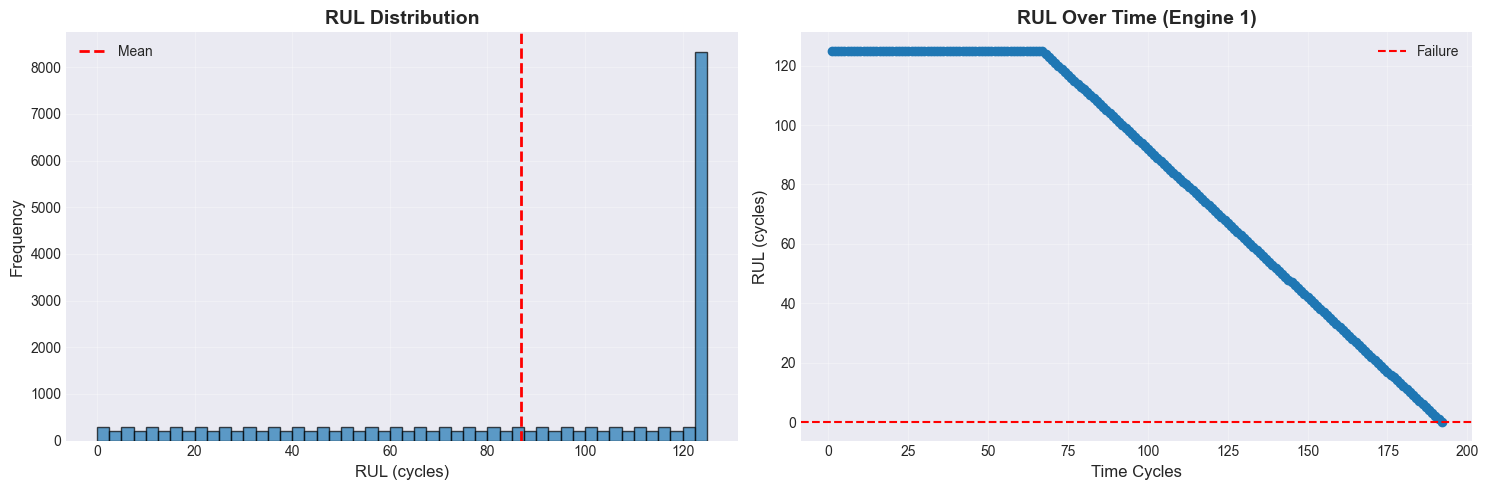


 Notice:
   - RUL decreases as engine approaches failure
   - RUL is clipped at 125 (early cycles have same RUL)
   - This creates a piece-wise linear degradation model


In [4]:
def create_rul(df, max_rul=125):
    max_cycles = df.groupby('unit_id')['time_cycles'].max().reset_index()
    max_cycles.columns = ['unit_id', 'max_cycle']

    df_with_max = df.merge(max_cycles, on='unit_id', how='left')

    df_with_max['RUL'] = df_with_max['max_cycle'] - df_with_max['time_cycles']

    df_with_max['RUL'] = df_with_max['RUL'].clip(upper=max_rul)

    df_with_max = df_with_max.drop('max_cycle', axis=1)
    
    return df_with_max

train_with_rul = create_rul(train_clean, max_rul=125)

print("RUL Creation Summary")
print(f"\n RUL column created successfully!")
print(f"\n RUL Statistics:")
print(train_with_rul['RUL'].describe())

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].hist(train_with_rul['RUL'], bins=50, edgecolor='black', alpha=0.7)
axes[0].axvline(train_with_rul['RUL'].mean(), color='red', linestyle='--', linewidth=2, label='Mean')
axes[0].set_xlabel('RUL (cycles)', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('RUL Distribution', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

sample_engine = train_with_rul[train_with_rul['unit_id'] == 1]
axes[1].plot(sample_engine['time_cycles'], sample_engine['RUL'], marker='o', linewidth=2)
axes[1].set_xlabel('Time Cycles', fontsize=12)
axes[1].set_ylabel('RUL (cycles)', fontsize=12)
axes[1].set_title('RUL Over Time (Engine 1)', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)
axes[1].axhline(y=0, color='red', linestyle='--', label='Failure')
axes[1].legend()

plt.tight_layout()
plt.show()

print("\n Notice:")
print("   - RUL decreases as engine approaches failure")
print("   - RUL is clipped at 125 (early cycles have same RUL)")
print("   - This creates a piece-wise linear degradation model")

### 4. Rolling Windows Features

    Create rolling window statistics for sensors.
    
    Args:
        df: DataFrame with engine data
        sensors: List of sensor columns
        windows: List of window sizes
    
    Returns:
        DataFrame with rolling features added


In [5]:
def create_rolling_features(df, sensors, windows=[5, 10, 20]):
    df_rolled = df.copy()
    
    for sensor in sensors:
        for window in windows:
            df_rolled[f'{sensor}_rolling_mean_{window}'] = \
                df_rolled.groupby('unit_id')[sensor].transform(
                    lambda x: x.rolling(window=window, min_periods=1).mean()
                )

            df_rolled[f'{sensor}_rolling_std_{window}'] = \
                df_rolled.groupby('unit_id')[sensor].transform(
                    lambda x: x.rolling(window=window, min_periods=1).std()
                )

            df_rolled[f'{sensor}_rolling_min_{window}'] = \
                df_rolled.groupby('unit_id')[sensor].transform(
                    lambda x: x.rolling(window=window, min_periods=1).min()
                )

            df_rolled[f'{sensor}_rolling_max_{window}'] = \
                df_rolled.groupby('unit_id')[sensor].transform(
                    lambda x: x.rolling(window=window, min_periods=1).max()
                )
    
    return df_rolled

print("Creating Rolling Window Features")

key_sensors = useful_sensors[:5]
print(f"\n Creating rolling features for {len(key_sensors)} sensors")
print(f" Window sizes: [5, 10, 20] cycles")
print(f" Statistics: mean, std, min, max")

train_with_rolling = create_rolling_features(train_with_rul, key_sensors, windows=[5, 10, 20])

print(f"\n Rolling features created!")
print(f" New shape: {train_with_rolling.shape}")
print(f" Added {train_with_rolling.shape[1] - train_with_rul.shape[1]} new features")

print("\n Sample of rolling features for one engine:")
sample = train_with_rolling[train_with_rolling['unit_id'] == 1][['time_cycles', key_sensors[0],
                                                                   f'{key_sensors[0]}_rolling_mean_5',
                                                                   f'{key_sensors[0]}_rolling_mean_10',
                                                                   f'{key_sensors[0]}_rolling_std_5']].head(15)
display(sample)

Creating Rolling Window Features

 Creating rolling features for 5 sensors
 Window sizes: [5, 10, 20] cycles
 Statistics: mean, std, min, max

 Rolling features created!
 New shape: (20631, 77)
 Added 60 new features

 Sample of rolling features for one engine:


,time_cycles,sensor_2,sensor_2_rolling_mean_5,sensor_2_rolling_mean_10,sensor_2_rolling_std_5
0,1,641.82,641.820000,641.820000,NaN
1,2,642.15,641.985000,641.985000,0.233345
2,3,642.35,642.106667,642.106667,0.267644
3,4,642.35,642.167500,642.167500,0.250117
4,5,642.37,642.208000,642.208000,0.234776
5,6,642.10,642.264000,642.190000,0.128374
6,7,642.48,642.330000,642.231429,0.139463
7,8,642.56,642.372000,642.272500,0.174270
8,9,642.12,642.326000,642.255556,0.208519
9,10,641.71,642.194000,642.201000,0.340705


Visualize rolling features

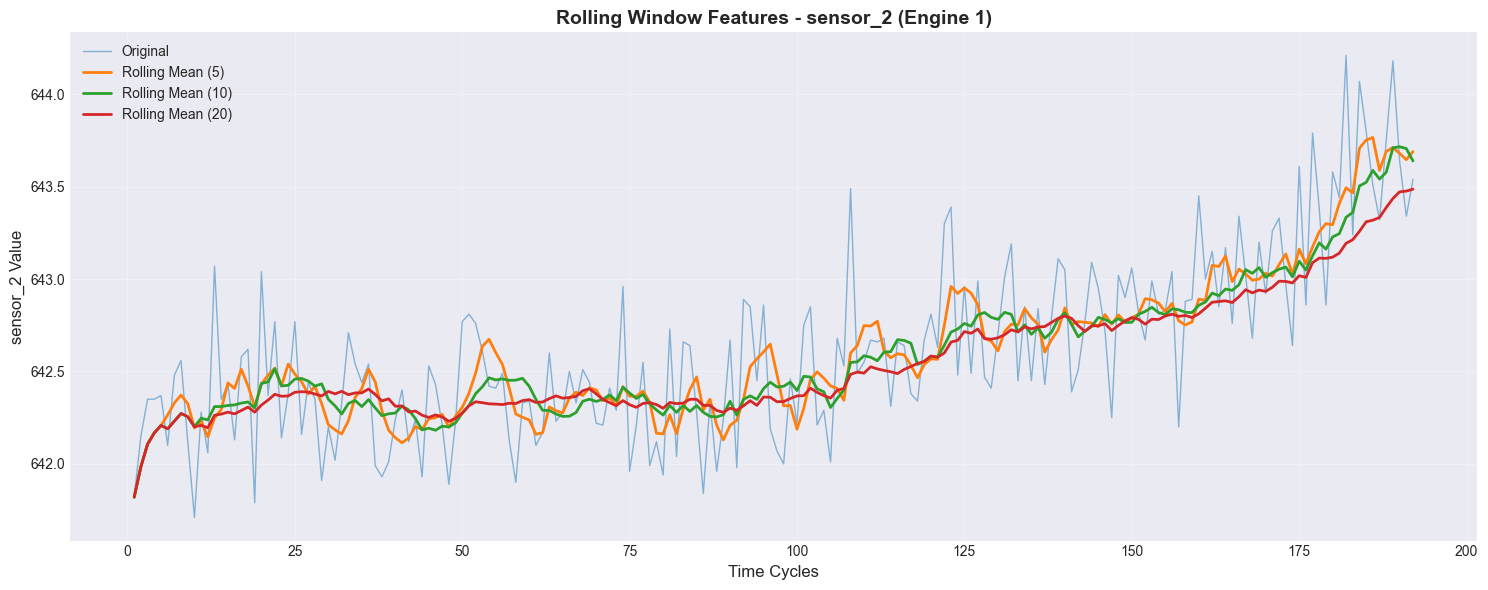

 Observations:
   - Larger windows = smoother curves
   - Rolling mean helps identify trends
   - Reduces impact of sensor noise


In [6]:

sample_engine_id = 1
sample_sensor = key_sensors[0]
engine_data = train_with_rolling[train_with_rolling['unit_id'] == sample_engine_id]

plt.figure(figsize=(15, 6))
plt.plot(engine_data['time_cycles'], engine_data[sample_sensor], 
         label='Original', linewidth=1, alpha=0.5)
plt.plot(engine_data['time_cycles'], engine_data[f'{sample_sensor}_rolling_mean_5'], 
         label='Rolling Mean (5)', linewidth=2)
plt.plot(engine_data['time_cycles'], engine_data[f'{sample_sensor}_rolling_mean_10'], 
         label='Rolling Mean (10)', linewidth=2)
plt.plot(engine_data['time_cycles'], engine_data[f'{sample_sensor}_rolling_mean_20'], 
         label='Rolling Mean (20)', linewidth=2)

plt.xlabel('Time Cycles', fontsize=12)
plt.ylabel(f'{sample_sensor} Value', fontsize=12)
plt.title(f'Rolling Window Features - {sample_sensor} (Engine {sample_engine_id})', 
          fontsize=14, fontweight='bold')
plt.legend(loc='best', fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(" Observations:")
print("   - Larger windows = smoother curves")
print("   - Rolling mean helps identify trends")
print("   - Reduces impact of sensor noise")

### 5. Degradation Features

    Create features that capture degradation patterns.


In [7]:
def create_degradation_features(df, sensors):
    df_deg = df.copy()
    
    for sensor in sensors:
        df_deg[f'{sensor}_rate_of_change'] = \
            df_deg.groupby('unit_id')[sensor].diff().fillna(0)

        df_deg[f'{sensor}_cumsum'] = \
            df_deg.groupby('unit_id')[f'{sensor}_rate_of_change'].cumsum()

        initial_values = df_deg.groupby('unit_id')[sensor].transform('first')
        df_deg[f'{sensor}_diff_from_start'] = df_deg[sensor] - initial_values

        if f'{sensor}_rolling_mean_5' in df_deg.columns:
            df_deg[f'{sensor}_trend'] = \
                df_deg[f'{sensor}_rolling_mean_5'] - \
                df_deg[f'{sensor}_rolling_mean_20']
    
    return df_deg

print("Creating Degradation Features")

train_with_deg = create_degradation_features(train_with_rolling, key_sensors)

print(f"\n Degradation features created!")
print(f" New shape: {train_with_deg.shape}")
print(f" Added {train_with_deg.shape[1] - train_with_rolling.shape[1]} new features")

deg_cols = [col for col in train_with_deg.columns if 'rate_of_change' in col or 'cumsum' in col or 'diff_from_start' in col or 'trend' in col]
print(f"\n Degradation features created:")
for col in deg_cols[:8]:
    print(f"   • {col}")

Creating Degradation Features

 Degradation features created!
 New shape: (20631, 97)
 Added 20 new features

 Degradation features created:
   • sensor_2_rate_of_change
   • sensor_2_cumsum
   • sensor_2_diff_from_start
   • sensor_2_trend
   • sensor_3_rate_of_change
   • sensor_3_cumsum
   • sensor_3_diff_from_start
   • sensor_3_trend


Visualize degradation features

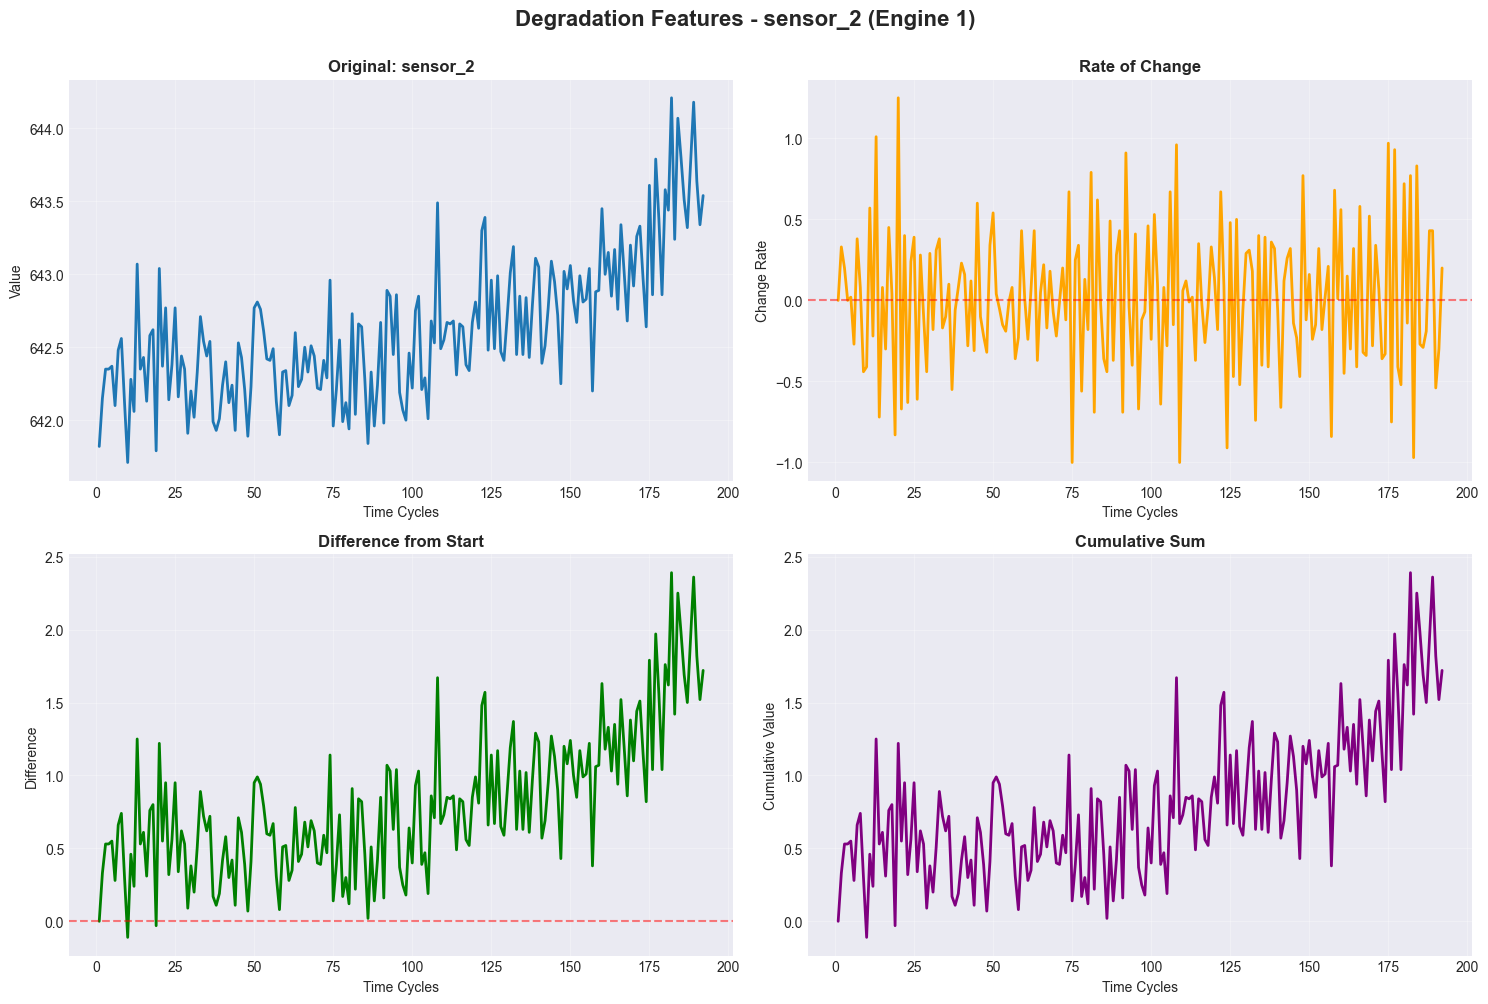

 What these show:
   - Rate of change: Velocity of degradation
   - Diff from start: Total drift from baseline
   - Cumulative sum: Accumulated wear over time


In [8]:

sample_engine_id = 1
sample_sensor = key_sensors[0]
engine_data = train_with_deg[train_with_deg['unit_id'] == sample_engine_id]

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

axes[0, 0].plot(engine_data['time_cycles'], engine_data[sample_sensor], linewidth=2)
axes[0, 0].set_title(f'Original: {sample_sensor}', fontweight='bold')
axes[0, 0].set_xlabel('Time Cycles')
axes[0, 0].set_ylabel('Value')
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].plot(engine_data['time_cycles'], engine_data[f'{sample_sensor}_rate_of_change'], 
                linewidth=2, color='orange')
axes[0, 1].axhline(y=0, color='red', linestyle='--', alpha=0.5)
axes[0, 1].set_title('Rate of Change', fontweight='bold')
axes[0, 1].set_xlabel('Time Cycles')
axes[0, 1].set_ylabel('Change Rate')
axes[0, 1].grid(True, alpha=0.3)

axes[1, 0].plot(engine_data['time_cycles'], engine_data[f'{sample_sensor}_diff_from_start'], 
                linewidth=2, color='green')
axes[1, 0].axhline(y=0, color='red', linestyle='--', alpha=0.5)
axes[1, 0].set_title('Difference from Start', fontweight='bold')
axes[1, 0].set_xlabel('Time Cycles')
axes[1, 0].set_ylabel('Difference')
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].plot(engine_data['time_cycles'], engine_data[f'{sample_sensor}_cumsum'], 
                linewidth=2, color='purple')
axes[1, 1].set_title('Cumulative Sum', fontweight='bold')
axes[1, 1].set_xlabel('Time Cycles')
axes[1, 1].set_ylabel('Cumulative Value')
axes[1, 1].grid(True, alpha=0.3)

plt.suptitle(f'Degradation Features - {sample_sensor} (Engine {sample_engine_id})', 
             fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

print(" What these show:")
print("   - Rate of change: Velocity of degradation")
print("   - Diff from start: Total drift from baseline")
print("   - Cumulative sum: Accumulated wear over time")

### 6. Time-Based Features

In [9]:
def create_time_features(df):
    df_time = df.copy()

    max_cycles = df_time.groupby('unit_id')['time_cycles'].transform('max')

    df_time['cycle_ratio'] = df_time['time_cycles'] / max_cycles

    df_time['lifecycle_stage'] = pd.cut(df_time['cycle_ratio'], 
                                         bins=[0, 0.33, 0.67, 1.0],
                                         labels=['early', 'mid', 'late'])

    df_time['cycles_remaining'] = max_cycles - df_time['time_cycles']

    df_time['log_time_cycles'] = np.log1p(df_time['time_cycles'])

    df_time['time_cycles_squared'] = df_time['time_cycles'] ** 2
    
    return df_time

print("Creating Time-Based Features")

train_with_time = create_time_features(train_with_deg)

print(f"\n Time-based features created!")
print(f" New shape: {train_with_time.shape}")

print("\n Lifecycle Stage Distribution:")
print(train_with_time['lifecycle_stage'].value_counts())

print("\n Sample time features:")
sample = train_with_time[train_with_time['unit_id'] == 1][[
    'time_cycles', 'cycle_ratio', 'lifecycle_stage', 
    'cycles_remaining', 'RUL'
]].head(10)
display(sample)

Creating Time-Based Features

 Time-based features created!
 New shape: (20631, 102)

 Lifecycle Stage Distribution:
lifecycle_stage
mid      6999
late     6865
early    6767
Name: count, dtype: int64

 Sample time features:


,time_cycles,cycle_ratio,lifecycle_stage,cycles_remaining,RUL
0,1,0.005208,early,191,125
1,2,0.010417,early,190,125
2,3,0.015625,early,189,125
3,4,0.020833,early,188,125
4,5,0.026042,early,187,125
5,6,0.031250,early,186,125
6,7,0.036458,early,185,125
7,8,0.041667,early,184,125
8,9,0.046875,early,183,125
9,10,0.052083,early,182,125


### 7. Statistical Features (Lag Features)

In [10]:
def create_lag_features(df, sensors, lags=[1, 2, 5]):
    df_lag = df.copy()
    
    for sensor in sensors:
        for lag in lags:
            df_lag[f'{sensor}_lag_{lag}'] = \
                df_lag.groupby('unit_id')[sensor].shift(lag).fillna(method='bfill')
    
    return df_lag

print("Creating Lag Features")

train_with_lags = create_lag_features(train_with_time, key_sensors[:3], lags=[1, 2, 5])

print(f"\n Lag features created!")
print(f" New shape: {train_with_lags.shape}")

print("\n Sample lag features:")
sample_sensor = key_sensors[0]
sample = train_with_lags[train_with_lags['unit_id'] == 1][[
    'time_cycles', sample_sensor, 
    f'{sample_sensor}_lag_1',
    f'{sample_sensor}_lag_2',
    f'{sample_sensor}_lag_5'
]].head(10)
display(sample)

Creating Lag Features

 Lag features created!
 New shape: (20631, 111)

 Sample lag features:


,time_cycles,sensor_2,sensor_2_lag_1,sensor_2_lag_2,sensor_2_lag_5
0,1,641.82,641.82,641.82,641.82
1,2,642.15,641.82,641.82,641.82
2,3,642.35,642.15,641.82,641.82
3,4,642.35,642.35,642.15,641.82
4,5,642.37,642.35,642.35,641.82
5,6,642.10,642.37,642.35,641.82
6,7,642.48,642.10,642.37,642.15
7,8,642.56,642.48,642.10,642.35
8,9,642.12,642.56,642.48,642.35
9,10,641.71,642.12,642.56,642.37


### 8. Feature Scaling

In [11]:
from sklearn.preprocessing import StandardScaler

print("Feature Scaling")

cols_to_scale = [col for col in train_with_lags.columns 
                 if col not in ['unit_id', 'RUL', 'lifecycle_stage']]

print(f"\n Scaling {len(cols_to_scale)} features")
print(f" Method: StandardScaler (Z-score normalization)")

scaler = StandardScaler()

train_scaled = train_with_lags.copy()
train_scaled[cols_to_scale] = scaler.fit_transform(train_scaled[cols_to_scale])

print(f"\n Features scaled!")

print("\n Before scaling:")
print(train_with_lags[key_sensors[0]].describe())

print("\n After scaling:")
print(train_scaled[key_sensors[0]].describe())

print("\n Notice:")
print("   - Mean ≈ 0")
print("   - Std ≈ 1")
print("   - All features now on same scale")

Feature Scaling

 Scaling 108 features
 Method: StandardScaler (Z-score normalization)

 Features scaled!

 Before scaling:
count    20631.000000
mean       642.680934
std          0.500053
min        641.210000
25%        642.325000
50%        642.640000
75%        643.000000
max        644.530000
Name: sensor_2, dtype: float64

 After scaling:
count    2.063100e+04
mean     6.410348e-14
std      1.000024e+00
min     -2.941625e+00
25%     -7.118085e-01
50%     -8.186036e-02
75%      6.380804e-01
max      3.697829e+00
Name: sensor_2, dtype: float64

 Notice:
   - Mean ≈ 0
   - Std ≈ 1
   - All features now on same scale


### 9. Handle Categorical Features

In [12]:
train_encoded = pd.get_dummies(train_scaled, columns=['lifecycle_stage'], prefix='stage')

print("Categorical Encoding")

print(f"\n Lifecycle stage one-hot encoded")
print(f" Final feature count: {train_encoded.shape[1]}")

stage_cols = [col for col in train_encoded.columns if 'stage_' in col]
print(f"\n Created columns: {stage_cols}")

Categorical Encoding

 Lifecycle stage one-hot encoded
 Final feature count: 113

 Created columns: ['stage_early', 'stage_mid', 'stage_late']


### 10 .Save Processed Data

In [13]:
import joblib

print("Saving Processed Data")

train_encoded.to_csv('../data/processed/train_processed.csv', index=False)
print("\n Saved: train_processed.csv")

joblib.dump(scaler, '../data/processed/scaler.pkl')
print(" Saved: scaler.pkl")

feature_cols = [col for col in train_encoded.columns if col not in ['unit_id', 'RUL']]
joblib.dump(feature_cols, '../data/processed/feature_columns.pkl')
print(" Saved: feature_columns.pkl")

print(f"\n Final processed data shape: {train_encoded.shape}")
print(f" Target variable: RUL")
print(f" Total features: {len(feature_cols)}")

Saving Processed Data

 Saved: train_processed.csv
 Saved: scaler.pkl
 Saved: feature_columns.pkl

 Final processed data shape: (20631, 113)
 Target variable: RUL
 Total features: 111
